In [1]:
%clear


In [2]:
import numpy as np
import tensorflow as tf
import datetime
# this code is used to check whether my gradient calculation can be used
import os
import sys
BASE_DIR = os.getcwd()
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense,Dropout,Conv2D,MaxPooling2D,Flatten
from tensorflow.keras.datasets import mnist
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam

print('current working dirctory = ',BASE_DIR)

current working dirctory =  /home/chaotang/文档/Try/2D


In [3]:
LOG_DIR = BASE_DIR + '/log'
# 设定了一个log 的路径，方便如何存入和读取模型
if not os.path.exists(LOG_DIR): os.mkdir(LOG_DIR)
print('current log dirctory = ',LOG_DIR)

current log dirctory =  /home/chaotang/文档/Try/2D/log


# digit recognition


In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

x_train = np.reshape(x_train,[60000,28,28,1])
x_test = np.reshape(x_test,[10000,28,28,1])

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)
(60000,)
(10000,)


In [5]:
# 传统的定义方法
def digitNet(x,label):
    conv1 = Conv2D(32,(5,5),activation = 'relu',name = 'conv1')(x)
    #print('conv1',conv1.shape) #(20, 26, 26, 32)
    MP1 = MaxPooling2D(pool_size=(2, 2),name = 'MP1')(conv1)
    #print('MP1',MP1.shape) # (20, 13, 13, 32)
    conv2 = Conv2D(32,(3,3),activation = 'relu',name = 'conv2')(MP1)
    #print('conv2',conv2.shape) # (20, 11, 11, 32)
    MP2 = MaxPooling2D(pool_size=(2, 2),name = 'MP2')(conv2)
    #print('MP2',MP2.shape) # (20, 5, 5, 32)
    # Dp1 =Dropout(rate = 0.2,name = 'Dp1')(MP1)
    # go down one more. Add one more conv and one more mp
    # leave the dp1
    Flat = Flatten()(MP2)
    #print('Flat',Flat.shape) # (20, 800)
    fc1 = Dense(128,activation = 'relu',name = 'fc1')(Flat)
    #out = Dense(10,activation = 'softmax',name = 'out')(fc1)
    #print('fc1',fc1.shape) # (20, 128)
    Dp1 =Dropout(rate = 0.3,name = 'Dp1')(fc1)
    out = Dense(10,name = 'out')(Dp1)
    
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=out, labels=label)
    return loss, out

# Check the structure of the Network

In [6]:
# 训练数字识别器，loss function选择了和POINTNER++一样的方式去构建 
tf.reset_default_graph()
batchsize = 20
x_pl = tf.placeholder(tf.float32,shape = [batchsize,28,28,1],name = 'x_pl')
label_pl = tf.placeholder(tf.int32,shape = [batchsize],name = 'label_pl')

loss,output = digitNet(x_pl,label_pl)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


# Add noise

test_label 0
test_img (20, 28, 28, 1)
Noise_img (20, 28, 28, 1)


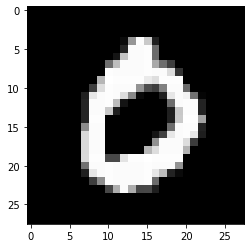

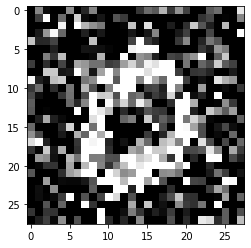

In [7]:
#print('networkoutput = ',networkoutput)
test_index = 3
test_img = np.zeros((20,28,28,1))

test_img[0] = x_test[test_index].reshape(1,28,28,1)
test_label = y_test[test_index].astype('int32')
print('test_label',test_label)
# add Noise
Noise_img = test_img + 0.5* np.random.normal(size = (1,28,28,1))
Noise_img = np.clip(Noise_img,0,1)
print('test_img',test_img.shape)
print('Noise_img',Noise_img.shape)
plt.figure()
plt.imshow(test_img[0].reshape((28,28)),cmap='gray')
plt.figure()
plt.imshow(Noise_img[0].reshape((28,28)),cmap='gray')

In [8]:
# 上面图过后成功完成训练了，接下来就是保存模型并提取模型，然后用自编码模型完成老师的任务了
# restore the model
# also remember to reset_everything to defaut!!!
tf.reset_default_graph()
batchsize = 20
MODEL_PATH = os.path.join(LOG_DIR,'MydigitNet.ckpt')
# Have to redifine Graph
x_pl = tf.placeholder(tf.float32,shape = [batchsize,28,28,1],name = 'x_pl')
label_pl = tf.placeholder(tf.int32,shape = [batchsize],name = 'label_pl')

_,output = digitNet(x_pl,label_pl)

saver = tf.train.Saver()

with tf.Session() as sess: 
    saver.restore(sess, MODEL_PATH)
    print("Model restored.")
    # 设置输出小数点位数
    np.set_printoptions(precision=2)
    print('test_label = ',test_label)
    feed1 = {x_pl:test_img}
    networkoutput_re = sess.run(output,feed_dict =feed1)
    print('networkoutput_re',networkoutput_re[0])
    Origin_prediction = np.argmax(networkoutput_re)
    print('Origin_prediction',Origin_prediction)
    
    feed2 = {x_pl:Noise_img}
    NoiseOutput = sess.run(output,feed_dict =feed2)
    print('NoiseOutput',NoiseOutput[0,:])
    Noise_prediction = np.argmax(NoiseOutput[0])
    print('Noise_prediction',Noise_prediction)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/chaotang/文档/Try/2D/log/MydigitNet.ckpt
Model restored.
test_label =  0
networkoutput_re [ 22.25 -20.55  -6.05 -13.07  -5.26  -5.93  -3.7   -9.31  -7.48  -4.21]
Origin_prediction 0
NoiseOutput [ 5.18 -7.53  0.78 -2.12 -1.71  0.4  -6.62 -3.19 -3.77 -3.75]
Noise_prediction 0


In [9]:
# 上面图过后成功完成训练了，接下来就是保存模型并提取模型，然后用自编码模型完成老师的任务了
# restore the model
# also remember to reset_everything to defaut!!!
tf.reset_default_graph()

# 下文的NoiseOutput是上一个restore的输出结果，等价于Noiseoutput = digitNet(x_pl,label_pl)

batchsize = 20
MODEL_PATH = os.path.join(LOG_DIR,'MydigitNet.ckpt')
LOG_DIR2 = LOG_DIR + '/log2'
if not os.path.exists(LOG_DIR2): os.mkdir(LOG_DIR2)
print('current log dirctory = ',LOG_DIR2)
###############################
### Have to redifine Graph ####
###############################
# this is the new graph
x_pl = tf.placeholder(tf.float32,shape = [batchsize,28,28,1],name = 'x_pl')
# x_pl = Noise_img
label_pl = tf.placeholder(tf.int32,shape = [batchsize],name = 'label_pl')

deltax = tf.get_variable('deltax',dtype=tf.float32,shape = x_pl.shape,initializer = tf.zeros_initializer)
# 必须要固定shape 才行，否则不允许如此设定变量

New_x = tf.clip_by_value((x_pl + deltax),0,1)# this may need a clip operation
#New_x = x_pl + deltax

loss,output = digitNet(New_x,label_pl)
pre_trained_list = []
var_list = []
for var in tf.trainable_variables():
    print(var.name)
    var_list.append(var)
pre_trained_list = var_list[1:]
print('###############################')
for var in pre_trained_list:
    print(var.name)
print('This is the train-graph name')
print('###############################')

saver = tf.train.Saver(var_list=pre_trained_list)

##################################
####### Graph has been redefine###
#################################
# 训练条件配置
train_var = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope = 'deltax:0')
displacement_mat = np.zeros((500,28,28,1)) # store the displacement for every 100 iteration
##############################################################
with tf.Session() as sess:
    sess.run(tf.variables_initializer([deltax]))
    saver.restore(sess,MODEL_PATH)
    print("Model restored.")
    #print('NoiseOutput',NoiseOutput[0])
    print('TestLabel',test_label)
    # define loss function (energy) 
    # E1 = deltaX^2
    E1 =  0.8 * tf.reduce_sum(tf.square(deltax[0])) # this become a scalar/// the shape of deltax[0] = (28,28,1)
    # E2 = Si ^ 2
    E2 = - output[0,test_label]
    
    energy_total = E1 + E2
    # optimizer define
    optimizer = tf.train.GradientDescentOptimizer(0.01)
    train_op = optimizer.minimize(energy_total,var_list = train_var)
    feed = {x_pl:Noise_img}
    print('Noise_img',Noise_img.shape)
    for i in range(500):
        _,loss_in_loop = sess.run([train_op,energy_total],feed_dict = feed)
        #print('energy_total',loss_in_loop)
      
        #if i%1 ==0:
           # j = int(i/1)
            #displacement_mat[j,...] = deltax[0].eval()  
        
    print('deltax= ',deltax[0].eval().shape)
    displacement = deltax[0].eval()
    #print('displacement = ',displacement)

current log dirctory =  /home/chaotang/文档/Try/2D/log/log2
deltax:0
conv1/kernel:0
conv1/bias:0
conv2/kernel:0
conv2/bias:0
fc1/kernel:0
fc1/bias:0
out/kernel:0
out/bias:0
###############################
conv1/kernel:0
conv1/bias:0
conv2/kernel:0
conv2/bias:0
fc1/kernel:0
fc1/bias:0
out/kernel:0
out/bias:0
This is the train-graph name
###############################
INFO:tensorflow:Restoring parameters from /home/chaotang/文档/Try/2D/log/MydigitNet.ckpt
Model restored.
TestLabel 0
Noise_img (20, 28, 28, 1)
deltax=  (28, 28, 1)


In [10]:
# restore the model
# also remember to reset_everything to defaut!!!
tf.reset_default_graph()
print('displacement_mat',displacement_mat.shape)

MODEL_PATH = os.path.join(LOG_DIR,'MydigitNet.ckpt')
# Have to redifine Graph
x_pl = tf.placeholder(tf.float32,shape = [None,28,28,1],name = 'x_pl')
label_pl = tf.placeholder(tf.int32,shape = [None],name = 'label_pl')

loss,output = digitNet(x_pl,label_pl)

saver = tf.train.Saver()
print('test_label = ',test_label)
Noise_mat = np.zeros((500,28,28,1))
for i in range(500):
    Noise_mat[i,...] = Noise_img[0,...]
with tf.Session() as sess: 
    saver.restore(sess, MODEL_PATH)
    print("Model restored.")
    # 设置输出小数点位数
    np.set_printoptions(precision=10)
    
    
    feed1 = {x_pl:test_img}
    output1 = sess.run(output,feed_dict =feed1)
    
    feed2 = {x_pl:Noise_img}
    output2 = sess.run(output,feed_dict =feed2)
    
    feed3 = {x_pl:Noise_img + displacement.reshape(1,28,28,1)}
    output3 = sess.run(output,feed_dict =feed3)
    
    feed4 = {x_pl:Noise_mat[0:20,...] + displacement_mat[0:20,...]}
    output4 = sess.run(output,feed_dict =feed4)
    
    print('done with image output,calculating Error...')
    #################################################################
    ########### Then compute the classification error################
    #################################################################
    feed5 = {x_pl:x_train}
    trainset_out = sess.run(output,feed_dict =feed5)
    #print('trainset_out',trainset_out.shape)
    train_pred = np.argmax(trainset_out,1)
    #print('train_pred',train_pred.shape)
    correct_train = 0
    for i in range(train_pred.shape[0]):
        correct_train += int(train_pred[i]==y_train[i])
    print('The accuracy of classification in training set',correct_train/train_pred.shape[0])
    print('With correct case',correct_train)
    
    feed6 = {x_pl:x_test}
    testset_out = sess.run(output,feed_dict =feed6)
    test_pred = np.argmax(testset_out,1)
    correct_test = 0
    for i in range(test_pred.shape[0]):
        correct_test += int(test_pred[i]==y_test[i])
    print('The accuracy of classification in test set',correct_test/test_pred.shape[0])
    print('With correct case',correct_test)

displacement_mat (500, 28, 28, 1)
test_label =  0
INFO:tensorflow:Restoring parameters from /home/chaotang/文档/Try/2D/log/MydigitNet.ckpt
Model restored.
done with image output,calculating Error...
The accuracy of classification in training set 0.9971666666666666
With correct case 59830
The accuracy of classification in test set 0.9908
With correct case 9908


Original score for testLabel=  22.248114
Original output =  [ 22.248 -20.547  -6.052 -13.074  -5.259  -5.925  -3.701  -9.308  -7.484
  -4.211]
Noise score for testLabel=  5.182901
Noise output =  [ 5.183 -7.527  0.776 -2.12  -1.711  0.401 -6.623 -3.185 -3.774 -3.75 ]
New score for testLabel=  24.872755
New output=  [ 24.873 -16.115  -0.189 -11.359  -8.728  -5.34   -3.991  -9.432   0.85
 -15.004]
different =  0.011013875539053817


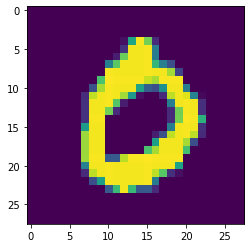

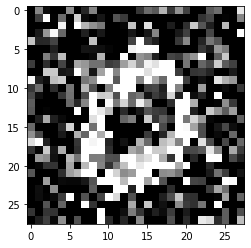

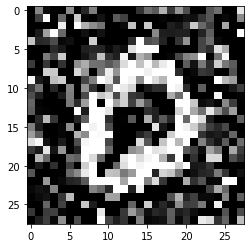

In [11]:
# 设置输出小数点位数
np.set_printoptions(precision=3)
plt.imshow(test_img[0].reshape((28,28)))
print('Original score for testLabel= ',output1[0,test_label]) #test_label
print('Original output = ',output1[0,:]) #test_label

plt.figure()
Old_noise = np.clip(Noise_img[0],0,1).reshape((28,28))
plt.imshow(Old_noise,cmap = 'gray')
print('Noise score for testLabel= ',output2[0,test_label])
print('Noise output = ',output2[0,:]) #test_label

plt.figure()
# Change 
Processed = np.clip(Noise_img[0] + displacement,0,1).reshape((28,28))
plt.imshow(Processed,cmap='gray')
print('New score for testLabel= ',output3[0,test_label])
print('New output= ',output3[0,:])

print('different = ',  np.square(Processed-Old_noise).mean())

#for count in range(20):
    #plt.figure()
    #Processed = np.clip(Noise_img[0] + displacement_mat[count,...],0,1).reshape((28,28))
    #plt.imshow(Processed)
    #print('New score for iter= ',output4[count,test_label])
    #print('New output this iter= ',output4[count,:])

In [12]:
from tensorflow.image import psnr
Processed = Processed.reshape((28,28,1))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    psnr_1 = psnr(test_img[0],Processed,max_val = 1.0)
    psnr_2 = psnr(test_img[0],Noise_img[0],max_val = 1.0)
    output_1,output_2 = sess.run([psnr_1,psnr_2])
    print('processed psnr = ',output_1)
    print('noisy psnr = ',output_2)


processed psnr =  9.301255
noisy psnr =  8.972099
